<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr/blob/main/Assignemnts_solutions/AssignmentXXXX_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 11


## Important notes



## k-Nearest Neighbors

We will use the loaded Iris data describing iris flowers
and shows relations between their length and petal width for three
species (namely: setosa, versicolor, virginica).

For this exercise we will restrict our analysis to just two variables: **petal length** and **petal width**.

In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

In [2]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [3]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
mnist_train_data_uint8 = mnist_full_train_data_uint8[:50000]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:50000]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[50000:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[50000:]

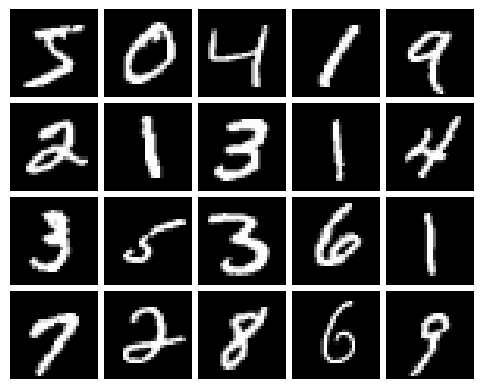

In [4]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

## Problem 6 kNN cosine [2p]

In previous problems you've discovered how to compute nearest neighbors using Euclidian distance. However, Euclidian distance is not the only one that you can use. 

In Machine Learning very often we calculate similarity between vectors using the dot product or the correlation coefficient between them, which we can also call the cosine similarity. You will see this in Deep Learning class in Convolutional Neural Networks for Image Recognition tasks, and in Transformers for Natural Language Processing.

Let $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors. Their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.



To get an idea why it can work let us plot the correlation matrix for an ordered (according to the 0,1,...,9 labels) subset of the MNIST data.

In [5]:
X_subset = mnist_train_data_uint8[:2000].reshape((-1,28*28))
y_subset = mnist_train_labels_int64[:2000]

In [6]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

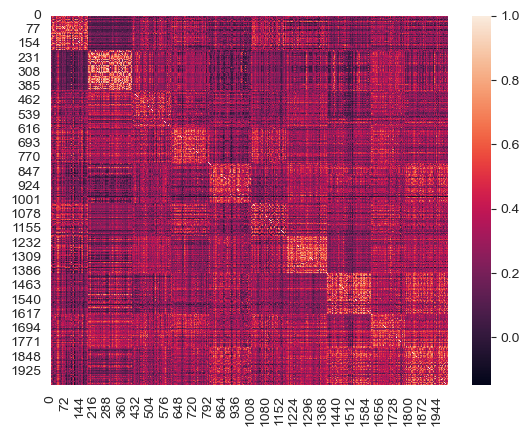

In [7]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

You can see that squares at the diagonal are brighter. It's because these squares correspond to the vectors with the same labels.

## Locality Sensitive Hashing

In previous  using loops implicitly present in matrix multiplication instead of explicit loops in Python. In this problem, we will explore a strategy to truly reduce the total number of computations required to find nearest neighbors without sacrificing too much accuracy.

To speed up nearest neighbor search we will employ *Locality Sensitive Hashing (LSH)* functions. For a given distance metric, the locality sensitive hash should put items that are similar into the same bucket. Notice that this is essentially a design choice opposite to traditional cryptographic hash functions that should amplify the difference of similar inputs (typically we want that small perturbations of data result in large changes to the hash value).

One of the simplest implementations of LSH approximates is actually for the cosine similarity. Recall from the previous problem that when $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors, then their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.

We will construct a family $H$ of hash functions that are an LSH for angle distances (an approximation to cosine similarity). Assume $p\in \mathbb{R}^N$ is a random vector (components are sampled from the normal distribution) of length 1. Then define the hash function $h(x) = \text{sgn}(x\cdot p)$, where $\text{sgn()}$ is the sign function. It can be proven that:

\begin{equation}
    \mathbb{P}_{h\in H}[h(x)=h(y)] = 1 - \frac{\theta(x,y)}{\pi}.
\end{equation}

This hash function basically just says if vectors $x$ and $y$ are on the same side of the hyperplane orthogonal to $p$.
The equation means that the probability of a hash collision (or equivalently being on the same side of the hyperplane) grows as the the angle between two vectors gets smaller. Therefore, vectors that are close according to the cosine similarity will be put with high probability into the same bin (we use the fact that for small $\theta$ we can approximate $\cos(\theta) = 1 - \theta/\pi$.

### Amplification  

We can leverage the above observation by taking multiple hyperplanes. 
Suppose we have many hash functions $h_1,h_2,...,h_r$ from $H$, and we consider an amplified hash function $h = \left( h_1,h_2,...,h_r\right)$ (value of $h$ is a vector of functions' values). Show that 

\begin{equation}
    \mathbb{P}_{h}[h(x)=h(y)] = \left(1 - \frac{\theta(x,y)}{\pi}\right)^r.
\end{equation}


What does it mean geometrically? For the purpose of these considerations we can assume that the vectors of MNIST digits lie on a sphere in 784 dimensions. In three dimensions our hashing would look like this:

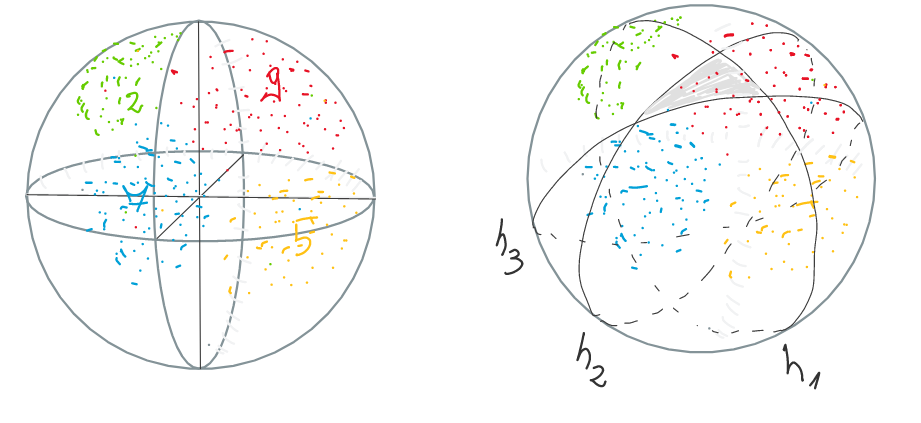

## Example on feature building

After creating $r$ hash functions we can look at the hashing as transforming the dataset into a new set of features, i.e., features $(x^i_1,x^i_2,...,x^i_n)$ of $i$th sample are mapped to $(h_1(x^i),h_2(x^i),...,h_r(x^i))$. On top of that there's a very important property from the math described above --- if $x^i$ and $x^j$ have a huge cosine similarity, then $h(x^i)$ and $h(x^j)$ will also have huge cosine similarity. On top of that, if $r$ is big enough, then the dataset in the new representation space may be easier to separate. Let's have a look.

In [18]:
X_train = mnist_train_data_uint8
y_train = mnist_train_labels_int64

X = X_train[:60000].reshape(-1,784)
y = y_train[:60000]




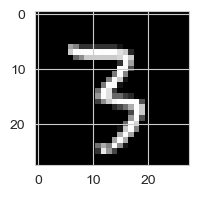

Label: 3


In [21]:
import matplotlib.pyplot as plt

def plot_digit(x):
    fig = plt.figure(figsize = (2,2))
    plt.imshow(x, cmap='gray')
    plt.show()

plot_digit(X[44].reshape(28,28))
print("Label:", y[44])



In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
clf = LogisticRegression(random_state=0).fit(X, y)

/Users/marek-ext/ml_uwr_22/venv_ml_uwr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
(clf.predict(X) == y).mean()

0.93346

Accuracy of Logistic Regresssion on the train set is something aroung `93.3%`.

Let's see LSH now in action

In [61]:
np.random.seed(2023)

cols = []
for i in range(2000):
    p = np.random.normal(size=(784,1))
    cols.append((np.sign(X @ p) + 1)/2)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [63]:
X_lsh = pd.DataFrame(data=np.hstack(cols))
X_lsh.shape

(50000, 2000)

In [64]:
clf = LogisticRegression(random_state=0).fit(X_lsh, y)

/Users/marek-ext/ml_uwr_22/venv_ml_uwr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
(clf.predict(X_lsh) == y).mean()

0.98374

And this is better than the initial accuracy!

### Task
Do the same hashing on train and test set to see if the accuracy on the test set also improves.

## Example of LSH on kNN

In [100]:
np.random.seed(2023)

X_lsh = dict()
for j in range(10):
    cols = []
    for i in range(10):
        p = np.random.normal(size=(784,1))
        cols.append((np.sign(X @ p) + 1)/2)
    X_lsh[j] = pd.DataFrame(data=np.hstack(cols))

In [101]:
X_lsh[0].value_counts()

0    1    2    3    4    5    6    7    8    9  
1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0    3226
     1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0    2609
     0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0    1433
               0.0  1.0  0.0  1.0  0.0  1.0  1.0    1411
0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0    1381
                                                    ... 
1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0       1
0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0       1
1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0       1
0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0       1
     0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0       1
Length: 789, dtype: int64

Above we can see the numbers of points that are hashed to the same feature. As noted before, points with huge similarity will be hashed to numbers with huge similarity as well. This gives an idea for a speedup of kNN algorithm --- instead of searching for nearest neighbors among all the points in the train dataset, we can only look at the neighbors hashed to the same hash. 

However, some clusters are very small and some are very huge. For the big ones, the answer most likely will be accurate, and the speed up will be of 20x less comparisons. However, some clusters have only one sample. For them we will not be able to give a meaningful answer. The idea is hence to do many hashings and for each sample to look at many hash groups. This way the likelihood of a sample ending up all the time in a small cluster is very small.

### Task
implement speed up for kNN based on this idea. Try to get 10x improvement. The improvement is not counted in terms of seconds or miliseconds. But rather for each sample calculate how many other points it had to scanned for the possibility of them being in their neighborhood. Average this number. You should be able to get 10x operations less at a cost of losing only 1 or 2 percent of accuracy.